# Infer MLE Params
Miguel Fuentes  
Created: 5/3/2020  
Last Updated: 5/4/2020

In [2]:
%matplotlib inline
from infection_models import sample_transmission, observe_transmission

from tqdm import tqdm
from collections import namedtuple
import matplotlib.pyplot as plt

import torch
from torch.distributions import constraints

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

pyro.set_rng_seed(101)

## Generate Data
First, I'll sample from "sample_transmission". This model is fully defined so I know what distributions all the paramaters are set to and what all the latent variables are coming from. I will only record the protocol which was used and how many people the individual infected, not the two latent variables.

In [3]:
n = 1000
data = []

for _ in range(n):
    protocol, contacted_people, infection_rate, num_infected = sample_transmission()
    data.append((protocol, num_infected))

## VI with Matching Guide
First, I will run inference using a guide which has the same form as the actual model, I expect that this should work pretty well and converge to parameters which are equivalent to those for the data generating process

In [4]:
def matching_guide(data):
    q_normal_contact_loc = pyro.param('q_normal_contact_loc', torch.tensor(50.0), constraint=constraints.positive)
    q_normal_contact_scale = pyro.param('q_normal_contact_scale', torch.tensor(10.0), constraint=constraints.positive)
    q_normal_conc0 = pyro.param('q_normal_conc0', torch.tensor(10.0), constraint=constraints.positive)
    q_normal_conc1 = pyro.param('q_normal_conc1', torch.tensor(10.0), constraint=constraints.positive)

    q_distance_contact_loc = pyro.param('q_distance_contact_loc', torch.tensor(25.0), constraint=constraints.positive)
    q_distance_contact_scale = pyro.param('q_distance_contact_scale', torch.tensor(5.0), constraint=constraints.positive)
    q_distance_conc0 = pyro.param('guide_distance_conc0', torch.tensor(10.0), constraint=constraints.positive)
    q_distance_conc1 = pyro.param('guide_distance_conc1', torch.tensor(10.0), constraint=constraints.positive)
    
    for i, datum in enumerate(data):
        protocol, num_infected = datum
        if protocol == 'normal_behavior':
            contacted_people = pyro.sample(f'contacted_people_{i}', pyro.distributions.Normal(q_normal_contact_loc, q_normal_contact_scale))
            infection_rate = pyro.sample(f'infection_rate_{i}', pyro.distributions.Beta(q_normal_conc1, q_normal_conc0))
        elif protocol == 'social_distancing':
            contacted_people = pyro.sample(f'contacted_people_{i}', pyro.distributions.Normal(q_distance_contact_loc, q_distance_contact_scale))
            infection_rate = pyro.sample(f'infection_rate_{i}', pyro.distributions.Beta(q_distance_conc1, q_distance_conc0))
        else:
            raise ValueError(f'Data point {i} has protocol value {protocol}, expects values \'social_distancing\' or \'normal_behavior\'')


  1%|▉                                                                                 | 6/500 [00:08<11:24,  1.38s/it]C:\Users\Miguel\.conda\envs\pyro\lib\site-packages\pyro\infer\trace_elbo.py:138: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [09:49<00:00,  1.18s/it]


Text(0, 0.5, 'loss')

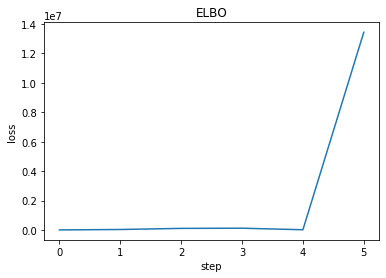

In [5]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=observe_transmission,
                     guide=matching_guide,
                     optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
                     loss=pyro.infer.Trace_ELBO())


losses = []
num_steps =500
for _ in tqdm(range(num_steps)):
    losses.append(svi.step(data))
    

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

In [6]:
losses[:20]

[4851.71502828598,
 33556.10681915283,
 109112.87855768204,
 120998.3556470871,
 16162.460183143616,
 13437752.106362343,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]